# Rippability binning

Goal: generate a regularly-sampled raster dataset of rippability estimates.

The raw rippability estimates come from water wells, which are scattered irregularly across the map. Generating a regularly-sampled raster is therefore an interpolation problem.

[Previous tests](./data/rippability_interpolation.ipynb) based on [Matt Hall's example](https://github.com/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb) showed good results from the [scipy.interpolate radial basis function (Rbf)](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) method, especially with the 'gaussian' option. But trying to run Rbf with 82,299 input points gives an error like this:

```
MemoryError: Unable to allocate 50.5 GiB for an array with shape (82299, 82299) and data type float64
```

This is clearly not scalable: for $ N $ points, the memory requirement is $ N^2 $! Why does it need to be one big matrix problem?

Let's try another strategy, similar to Gaussian [kernel smoothing](https://en.wikipedia.org/wiki/Kernel_smoother). The smoothed value for a given *output* point $ X_0 $ is

$$ Y(X_0) = \frac{\sum_{i=1}^N K(X_0, X_i) Y(X_i)}{\sum_{i=1}^N K(X_0, X_i)} $$

where $ K(X_0, X_i) $ is the Gaussian kernel

$$ K(X_0, X_i) = \exp \left( - \frac{(X_i - X_0)^2}{2 b^2} \right) $$

## Kernel function

In [1]:
import numpy

In [2]:
kernel_radius = 3600 # Meters

In [3]:
def kernel(x):
    normx = x / kernel_radius
    return numpy.exp(-0.5 * normx * normx)

In [4]:
import matplotlib.pyplot as plt

In [5]:
testwin = numpy.linspace(-4 * kernel_radius, 4 * kernel_radius, 81)

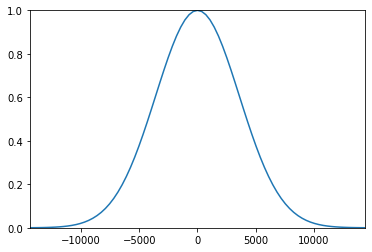

In [6]:
plt.plot(testwin, kernel(testwin))
plt.axis([-4 * kernel_radius, 4 * kernel_radius, 0, 1])
plt.show()

## Data Input

In [7]:
import pandas

In [8]:
data = pandas.read_csv('data/lonlatrip_0-20.csv')

In [9]:
data.head()

,SITE_ID,LONGITUDE,LATITUDE,RIPPABILITY
0,2634,-99.940438,35.616586,4.0
1,2635,-99.936163,35.603896,4.0
2,2636,-99.958340,35.607510,4.0
3,2637,-99.969458,35.605815,4.0
4,2638,-99.980415,35.604122,4.0


The raw data coordinates are longitude and latitude in degrees. For easier use in a tiled web map, we project these to Web Mercator X and Y ([EPSG 3857](https://epsg.io/3857)).

In [10]:
earth_radius = 6371008

In [11]:
def get_mercatorX(lon):
    lon = numpy.radians(lon)
    return earth_radius * lon

In [12]:
def get_mercatorY(lat):
    lat = numpy.radians(lat)
    exp_y = numpy.tan(numpy.pi / 4 + lat / 2)
    return earth_radius * numpy.log(exp_y)

In [13]:
data_xyv = pandas.DataFrame({
    'x': data['LONGITUDE'].map(get_mercatorX),
    'y': data['LATITUDE'].map(get_mercatorY),
    'val': data['RIPPABILITY']})

In [14]:
data_xyv.head()

,x,y,val
0,-1.111288e+07,4.243244e+06,4.0
1,-1.111241e+07,4.241508e+06,4.0
2,-1.111487e+07,4.242002e+06,4.0
3,-1.111611e+07,4.241770e+06,4.0
4,-1.111733e+07,4.241539e+06,4.0


## Output Grid

In [15]:
target_gridspace = 2000 # meters

We adjut the grid spacing to correspond to an integer zoom level in the web map tiling system. This correspondence is achieved by choosing a grid spacing equal to $ 2 \pi R_E \Big/ 2^Z N_T $, where $ R_E $ is the radius of the Earth, $ Z $ is the zoom level, and $ N_T $ is the number of pixels in a tile.

In [16]:
tilesize = 512

Solving for the zoom level, we have
$$ dg = \frac{2 \pi R_E}{2^Z N_T} \implies 2^Z = \frac{2 \pi R_E}{N_T dg} \implies Z = \log_2 \frac{2 \pi R_E}{N_T dg} $$

In [17]:
def get_zoom(dg):
    z = numpy.log2(2 * numpy.pi * earth_radius / tilesize / dg)
    return numpy.round(z)

In [18]:
maxzoom = get_zoom(target_gridspace)

Converting back into the exact gridspace gives

In [19]:
dg = 2 * numpy.pi * earth_radius / tilesize / 2 ** maxzoom

In [20]:
dg

2443.2509678664305

The following function inputs a range of Web Mercator x (or y) values, and outputs an array of the centers of the pixels that cover that range.

In [21]:
def get_grid1d(xmin, xmax, dx): 
    # Snap to nearest grid center. Note: first gridpoint is at dx / 2
    x1 = numpy.floor(xmin / dx) * dx + dx / 2
    x2 = numpy.floor(xmax / dx) * dx + dx / 2
    
    # Find the number of gridpoints spanning [xmin, xmax]
    ngrid = int( numpy.round((x2 - x1) / dx) ) + 1
    
    return numpy.linspace(x1, x2, ngrid)

In [22]:
gridx = get_grid1d(data_xyv.x.min(), data_xyv.x.max(), dg)

In [23]:
gridy = get_grid1d(data_xyv.y.min(), data_xyv.y.max(), dg)

NOTE: numpy.linspace modifies the grid spacing! (numpy.arange does the same)

In [24]:
gridx[1] - gridx[0] - dg

-6.207301339600235e-10

## Putting it all together

In [25]:
def grid_data(data, xgrid, ygrid, radius):
    # Initialize output arrays
    ny = len(ygrid)
    nx = len(xgrid)
    values = numpy.zeros((ny, nx))
    density = numpy.zeros((ny, nx))

    # Compute some window sizes in units of grid spacing
    dg = xgrid[1] - xgrid[0]
    halfwin = int( numpy.round(4 * radius / dg) )
    window = 2 * halfwin + 1
    
    def get_window_ends(x, x0, n):
        i0 = int(numpy.round((x - x0) / dg)) - halfwin
        i1 = i0 + window
        return max(0, i0), min(i1, n)
        
    def add_data(x, y, val):
        # Find the indices of the bottom left corner of the affected area
        ix0, ix1 = get_window_ends(x, xgrid[0], nx)
        iy0, iy1 = get_window_ends(y, ygrid[0], ny)
    
        # Compute the kernel values in X and Y
        xkernel = kernel(xgrid[ix0:ix1] - x)
        ykernel = kernel(ygrid[iy0:iy1] - y)
    
        # Accumulate kernel and kernel * data, row by row
        for i in range(len(ykernel)):
            rowkernel = xkernel * ykernel[i]
            density[iy0 + i,ix0:ix1] += rowkernel
            values[iy0 + i,ix0:ix1] += rowkernel * val

        return
    
    # Loop over data rows, accumulate results
    for index, row in data.iterrows():
        add_data(*row.values)
    
    # Normalize values
    values = numpy.divide(values, density, out=numpy.zeros_like(density), where=density>0.01)
    
    return values, density

**Note**: The following line runs the gridding for >100k data points. It may take a minute or two to finish!

In [26]:
vals, dens = grid_data(data_xyv, gridx, gridy, kernel_radius)

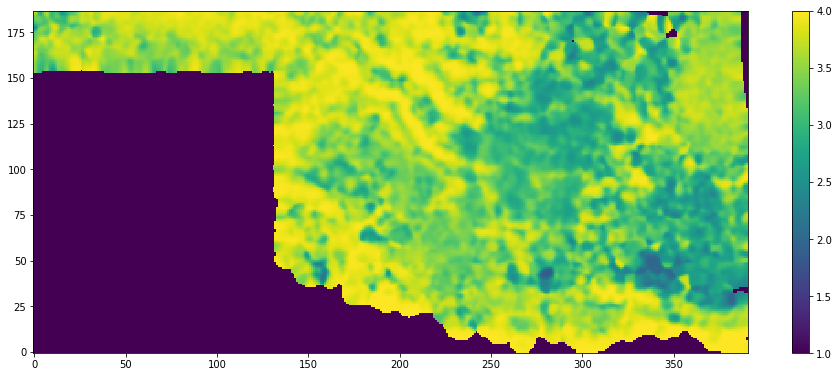

In [27]:
plt.figure(figsize=(16, 9))
c1 = plt.imshow(vals, origin="lower", vmin=1, vmax=4)
plt.colorbar(c1, shrink=0.7)
plt.show()

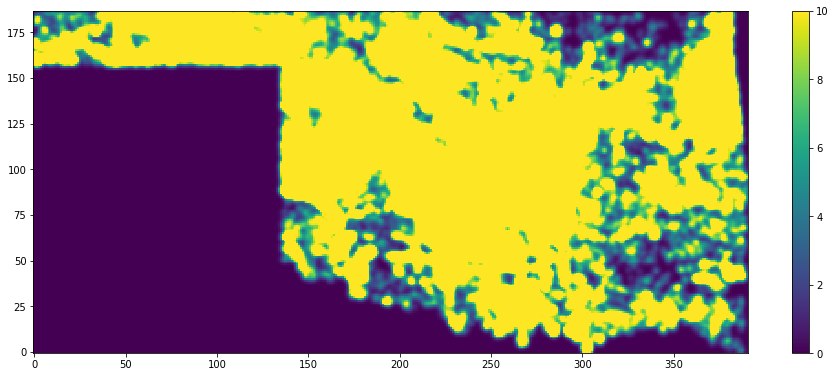

In [28]:
plt.figure(figsize=(16, 9))
c1 = plt.imshow(dens, origin="lower", vmin=0, vmax=10)
plt.colorbar(c1, shrink=0.7)
plt.show()

## TODO

- Compare different depths
- Adjust kernel radius for the local projection scale